Data Source: https://www.kaggle.com/START-UMD/gtd/data and http://start.umd.edu/gtd/

**Contents in the Notebook**

- <a href='#Part2'> Terrorism Around The World</a>
  - <a href='#Getting Data Ready2'> 1.1 Getting Data Ready</a>
  - <a href='basic-analysis'> 1.2 Some Basic Analysis</a>
  - <a href='#Global Attacks'>1.3 Global Terror Attacks</a>
  - <a href='#notorious-groups'>1.5 Most Notorious Groups</a>
  - <a href='#India'>1.6 Terror Activities in India</a>
  - <a href='#USA'>1.7 Terror Activities in USA</a>
  - <a href='#Motive'>1.8 Motive Behind Attacks</a>
  - <a href='#Animate'>1.9 World Terrorism Spread(Animation)</a>
  
### Potential predictions/classifications to make:
- Predicting if a instance of terrorism is doubted as terrorism proper (doubterr)
- Predicting # of terrorists in an attack (nperp) or # of terrorists captured (nperpcap)
- Classifying an attack as successful or not (success)
- Predict the group that carried out the attack <<<------------ Possibly the most interesting???

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sys 
import os
from scipy import stats
from scipy.stats import norm
plt.style.use('ggplot')
sys.path.append(os.path.abspath("../../shared"))
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
import feature_selection
import helpers
import eda
import preprocessing
%matplotlib inline

In [2]:
data = pd.read_csv('globalterrorismdb_0617dist.csv', encoding='ISO-8859-1')

/home/daniel/mlenv/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,6,31,33,53,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,targtype3,targtype3_txt,targsubtype3,targsubtype3_txt,corp3,target3,natlty3,natlty3_txt,gname,gsubname,gname2,gsubname2,gname3,gsubname3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,claim2,claimmode2,claimmode2_txt,claim3,claimmode3,claimmode3_txt,compclaim,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,Central America & Caribbean,NaN,Santo Domingo,18.456792,-69.951164,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,1,Assassination,NaN,NaN,NaN,NaN,14,Private Citizens & Property,68.0,Named Civilian,NaN,Julio Guzman,58.0,Dominican Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MANO-D,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,North America,NaN,Mexico city,19.432608,-99.133207,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,6,Hostage Taking (Kidnapping),NaN,NaN,NaN,NaN,7,Government (Diplomatic),45.0,"Diplomatic Personnel (outside of embassy, cons...",Belgian Ambassador Daughter,"Nadine Chaval, daughter",21.0,Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23rd of September Communist League,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,Mexico,1.0,800000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,Southeast Asia,Tarlac,Unknown,15.478598,120.599741,4.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,1,Assassination,NaN,NaN,NaN,NaN,10,Journalists & Media,54.0,Radio Journalist/Staff/Facility,Voice of America,Employee,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,Western Europe,Attica,Athens,37.983773,23.728157,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,7,Government (Diplomatic),46.0,Embassy/Consulate,NaN,U.S. Embassy,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,Explosives/Bombs/Dynamite,16.0,Unknown Explosive Type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Explosive,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,

<a id="basic-analysis">Some basic analysis</a>

In [4]:
data['casualties'] = data['nwound'] + data['nkill']

In [5]:
print('Country with Highest Terrorist Attacks:', data['country_txt'].value_counts().index[0])
print('Regions with Highest Terrorist Attacks:', data['region_txt'].value_counts().index[0])
kill_max = data.loc[data['nkill'].idxmax()]
print('Maximum killed in an attack are:', kill_max.nkill,'that took place in',kill_max.country_txt, 
      'on',kill_max.imonth,kill_max.iday,kill_max.iyear)
casualty_max = data.loc[data['casualties'].idxmax()]
print('Maximum casualties in an attack are:', casualty_max.casualties, 
      '(killed:',casualty_max.nkill ,',', 'injured:',casualty_max.nwound ,')'
      ,'that took place in',casualty_max.country_txt, 'on', casualty_max.imonth, casualty_max.iday, casualty_max.iyear)

('Country with Highest Terrorist Attacks:', u'Iraq')
('Regions with Highest Terrorist Attacks:', u'Middle East & North Africa')
('Maximum killed in an attack are:', 1500.0, 'that took place in', u'Iraq', 'on', 6, 12, 2014)
('Maximum casualties in an attack are:', 8749.0, '(killed:', 1383.0, ',', 'injured:', 7366.0, ')', 'that took place in', u'United States', 'on', 9, 11, 2001)


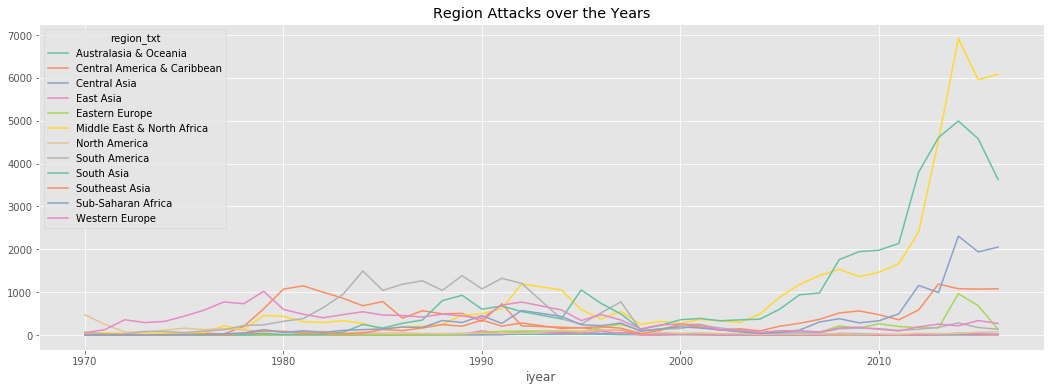

In [6]:
data_region=pd.crosstab(data.iyear,data.region_txt)
data_region.head()
data_region.plot(color=sns.color_palette('Set2',12))
fig=plt.gcf()
fig.set_size_inches(18,6)
plt.title('Region Attacks over the Years')
plt.show()

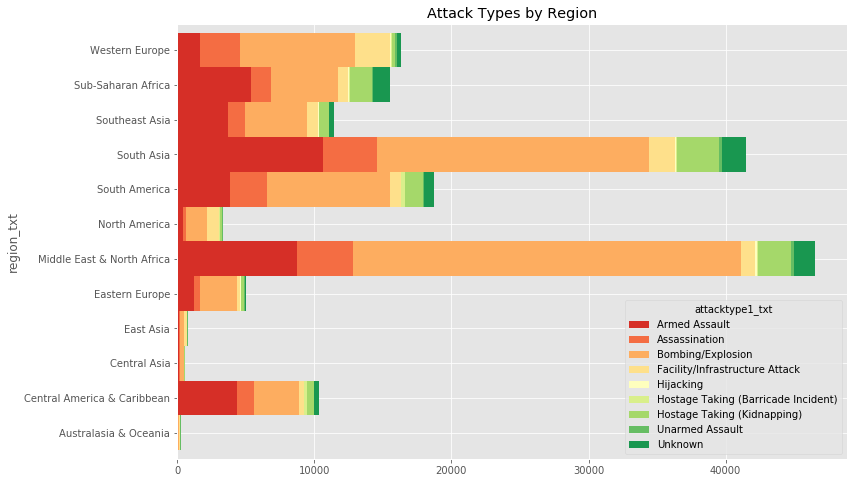

In [7]:
pd.crosstab(data.region_txt,data.attacktype1_txt).plot.barh(stacked=True,width=1,color=sns.color_palette('RdYlGn',9))
fig=plt.gcf()
fig.set_size_inches(12,8)
plt.title('Attack Types by Region')
plt.show()

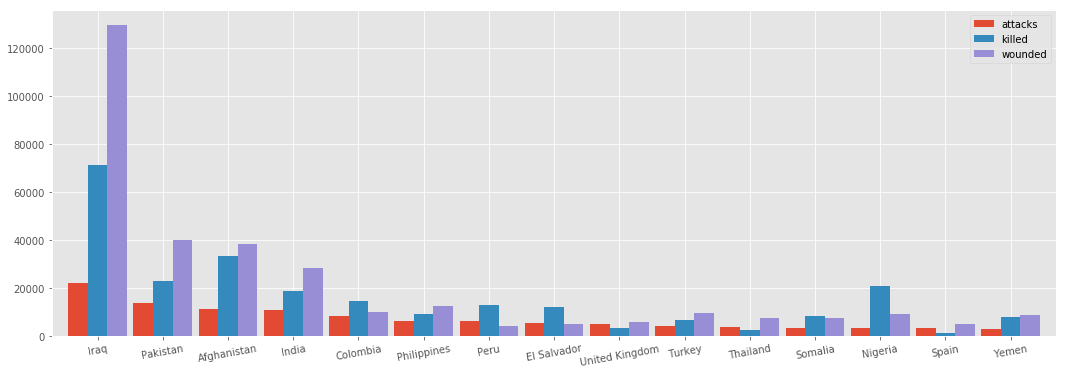

In [8]:
count_terror=data['country_txt'].value_counts()[:15].to_frame()
count_terror.columns=['attacks']
count_kill= data.groupby('country_txt')['nkill'].sum().to_frame()
count_kill.columns=['killed']
count_wound=data.groupby('country_txt')['nwound'].sum().to_frame()
count_wound.columns=['wounded']
# right_index=True and left_index=True will joing the the dataframes on the countries (which are the indexes in this case)
count_terror = count_terror.merge(count_kill,right_index=True,left_index=True, how='left')
count_terror = count_terror.merge(count_wound,left_index=True,right_index=True,how='left')
count_terror.plot.bar(width=0.9)
fig=plt.gcf()
fig.set_size_inches(18,6)
plt.xticks(rotation=10)
plt.show()

<a id='notorious-groups'>Most Notorious Groups</a>
### Key questions
- Which groups attack the most?
- Which groups are most "successful"?
- What kind of attacks do the groups who attack the most execute?
- Where do these groups attack?
- Who do these groups target?
- Do groups coordinate attacks in general?
- What is the motive of the most notorious groups?
- Average number of perpetrators for those groups?

In [9]:
notorious_groups = data[(data['gname'] != 'Unknown') & (data['gname'].isin(data.gname.value_counts().reset_index(name="count").query("count > 250")["index"]))]

Text(0.5,1,u'Most Notorious Groups - # of Attacks')

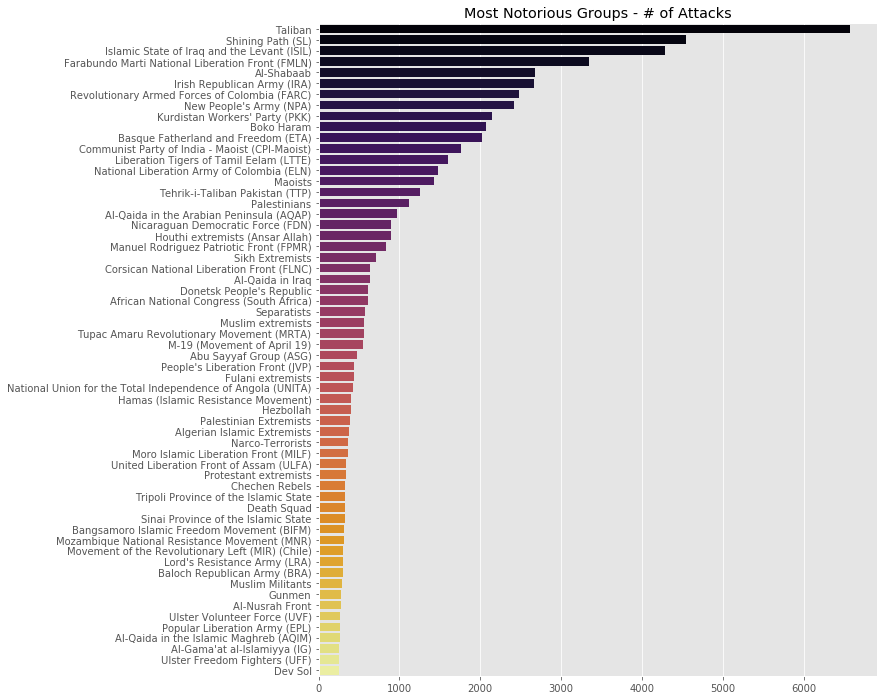

In [10]:
fig, ax = plt.subplots(figsize=(10,12))
sns.barplot(notorious_groups['gname'].value_counts().values,notorious_groups['gname'].value_counts().index,palette=('inferno'),ax=ax,);
plt.title('Most Notorious Groups - # of Attacks')

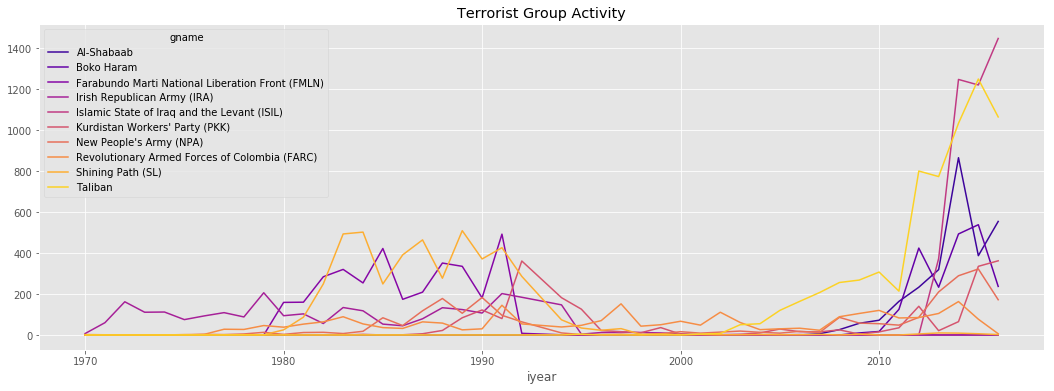

In [11]:
top_ten_groups=data[data['gname'].isin(data['gname'].value_counts()[1:11].index)]
pd.crosstab(top_ten_groups.iyear,top_ten_groups.gname).plot(color=sns.color_palette('plasma',10))
fig=plt.gcf()
fig.set_size_inches(18,6)
plt.title('Terrorist Group Activity')
plt.show()

In [12]:
data.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,targtype3,targtype3_txt,targsubtype3,targsubtype3_txt,corp3,target3,natlty3,natlty3_txt,gname,gsubname,gname2,gsubname2,gname3,gsubname3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,claim2,claimmode2,claimmode2_txt,claim3,claimmode3,claimmode3_txt,compclaim,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,casualties
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,Central America & Caribbean,NaN,Santo Domingo,18.456792,-69.951164,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,1,Assassination,NaN,NaN,NaN,NaN,14,Private Citizens & Property,68.0,Named Civilian,NaN,Julio Guzman,58.0,Dominican Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MANO-D,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN,1.0
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,North America,NaN,Mexico city,19.432608,-99.133207,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,6,Hostage Taking (Kidnapping),NaN,NaN,NaN,NaN,7,Government (Diplomatic),45.0,"Diplomatic Personnel (outside of embassy, cons...",Belgian Ambassador Daughter,"Nadine Chaval, daughter",21.0,Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23rd of September Communist League,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,Mexico,1.0,800000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN,0.0
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,Southeast Asia,Tarlac,Unknown,15.478598,120.599741,4.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,1,Assassination,NaN,NaN,NaN,NaN,10,Journalists & Media,54.0,Radio Journalist/Staff/Facility,Voice of America,Employee,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,1.0
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,Western Europe,Attica,Athens,37.983773,23.728157,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,7,Government (Diplomatic),46.0,Embassy/Consulate,NaN,U.S. Embassy,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,Explosives/Bombs/Dynamite,16.0,Unknown Explosive Type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Explosive,NaN,NaN,NaN

In [13]:
data[data['region_txt'] == 'Middle East & North Africa'].shape[0]

46511

In [45]:
def color_point(x):
    if x>=30:
        color='red'
    elif x >= 20:
        color='blue'
    elif x >= 3:
        color='purple'
    elif x >= 1:
        color='green'
    else:
        color='gray'
    return color   
def point_size(x):
    if (x>30 and x<100):
        size=2
    elif (x>=100 and x<500):
        size=8
    elif x>=500:
        size=16
    else:
        size=0.5
    return size   

def gen_terror_attack_map(area='Western Europe', threshold=data.shape[0]):
    import folium
    is_region=(area in data['region_txt'].unique())
    is_country=(area in data['country_txt'].unique())
    if not is_country and not is_region:
        print('Must give one of these areas:\n', data['region_txt'].unique(), data['country_txt'].unique())
        return;
    if is_region:
        terror=data[data['region_txt']==area]
    else:
        terror=data[data['country_txt']==area]
    terror_fol=terror.copy()
    terror_fol = terror_fol.sort_values(by='casualties', ascending=False)
    threshold = min(terror_fol.shape[0],threshold)
    terror_fol.dropna(subset=['latitude','longitude'],inplace=True)
    location=terror_fol[['latitude','longitude']][:threshold]
    city=terror_fol['city'][:threshold]
    
    killed=terror_fol['nkill'][:threshold]
    wounded=terror_fol['nwound'][:threshold]
    group=terror_fol['gname'][:threshold]
    casualty=terror_fol['casualties'][:threshold]
    target=terror_fol['targtype1_txt'][:threshold]
    target1=terror_fol['target1'][:threshold].fillna('No specific target')
    month_lst = ['Unknown','January', 'February', 'March', 'April', 'May', 'June', 'July',
              'August', 'September', 'October', 'November', 'December']
    month_mapping = {i: month_lst[i] for i in range(13)}
    month=terror_fol['imonth'][:threshold].map(month_mapping)
    day=terror_fol['iday'][:threshold]
    year=terror_fol['iyear'][:threshold]
    doubtterr = terror_fol['doubtterr'][:threshold].map({-9:'Not included', 0: 'No', 1:'Yes'})
    attacktype1 = terror_fol['attacktype1_txt'][:threshold]
    motive = terror_fol['motive'][:threshold].fillna('Unknown')
    # Need to replace apostrophes with its HTML code. 
    # See: https://stackoverflow.com/questions/46376591/why-does-mapping-in-folium-with-over-100-circle-markers-result-in-a-blank-map
    # For the record though, I actually figured that out myself (after a lot of headache)
    group = group.str.replace('\'','&#39;')
    city = city.str.replace('\'','&#39;')
    target = target.str.replace('\'','&#39;')
    attacktype1 = attacktype1.str.replace('\'','&#39;')
    target1 = target1.str.replace('\'','&#39;')
    motive = motive.str.replace('\'','&#39;')
    
    lat, lng = terror_fol['latitude'].dropna(), terror_fol['longitude'].dropna()
    std_lat_lng = max(lat.std(), lng.std())#(lat.std() + lng.std())/2
    if std_lat_lng > 7:
        zoom = 3.5
    elif std_lat_lng > 5:
        zoom = 5
    elif std_lat_lng > 1:
        zoom = 6
    else:
        zoom = 8.5
    map4 = folium.Map(location=[lat.mean(), lng.mean()],
                  tiles='CartoDB dark_matter',
                  zoom_start=zoom)

    for p in location.index:
        html =  '<b>Group: </b>' + group[p] + '<br>'
        html += '<b>City: </b>' + city[p] + '<br>'
        html += '<b>Date: </b>' + str(month[p]) + ' ' + str(day[p]) + ', ' + str(year[p]) + '<br>' 
        html += '<b>Target: </b>' + target[p] + ' - '+ target1[p].encode('utf-8') +'<br>' 
        html += '<b>Motive: </b>' + motive[p] + '<br>' 
        html += '<b>Attack Type: </b>' + attacktype1[p] + '<br>' 
        html += '<b>Killed: </b>' + str(killed[p]) + '<br>' 
        html += '<b>Wounded: </b>' + str(wounded[p]) + '<br>' 
        html += '<b>Terrorism Doubted: </b>' + doubtterr[p] + '<br>' 
        folium.CircleMarker(list(location.loc[p].values),
                            radius=point_size(casualty[p]),
                            popup=folium.Popup(html,max_width=450),
                            color=color_point(casualty[p]),
                            fill_color=color_point(casualty[p])
                     ).add_to(map4)
    print('casualties: gray = 0, green = < 3, purple = < 20, blue = < 30, red = >= 30 ')
    return map4

In [48]:
map4 = gen_terror_attack_map(area='Norway',threshold=100)
map4

casualties: gray = 0, green = < 3, purple = < 20, blue = < 30, red = >= 30 


In [ ]:
map4.save('middle_east_north_africa_attacks.html')

In [ ]:
import os
import time
from selenium import webdriver

delay=5
fn='middle_east_north_africa_attacks.html'
tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)

browser = webdriver.Firefox()
browser.get(tmpurl)
#Give the map tiles some time to load
time.sleep(delay)
browser.save_screenshot('map.png')
browser.quit()